In [30]:
import torch
import torch.nn as nn
import numpy as np

import gymnasium as gym

import matplotlib.pyplot as plt

from IPython.display import clear_output

env = gym.make("CartPole-v1", render_mode='rgb_array')
env.action_space.seed(42)

[42]

## Create Model

In [47]:
nS = 4 # dim вектора состояний
nA = 2 # число дискретных действий
nH1, nH2 = 64, 32 # нейронов в скрытых слоях

In [48]:
model = nn.Sequential(
    nn.Linear(nS, nH1),
    nn.ReLU(),
    nn.Linear(nH1, nH2),
    nn.ReLU(),
    nn.Linear(nH2, nA))
target = model

## Create Memory buffer

In [88]:
class Memory:
    def __init__(self, capacity, nS):
        self.capacity = capacity # вместимость памяти
        self.count = 0
        self.S0 = torch.empty((capacity, nS), dtype=torch.float32)
        self.S1 = torch.empty((capacity, nS), dtype=torch.float32)
        self.A0 = torch.empty((capacity, 1), dtype=torch.int64)
        self.R1 = torch.empty((capacity, 1), dtype=torch.float32)
        self.Dn = torch.empty((capacity, 1), dtype=torch.float32)

    def add(self, s0, a0, s1, r1, done):
        """ Add to memory (s0,a0,s1,rq) """
        idx = self.count % self.capacity
        self.S0[idx] = torch.tensor(s0, dtype=torch.float32)
        self.S1[idx] = torch.tensor(s1, dtype=torch.float32)
        self.A0[idx] = a0
        self.R1[idx] = r1
        self.Dn[idx] = done
        self.count += 1

    def get(self, count):
        """ Return count of examples for (s0,a1,s1,r1)"""
        high = min(self.count, self.capacity)
        num = min(count, high)
        ids = torch.randint(high=high, size=(num,))
        return self.S0[ids], self.A0[ids], self.S1[ids], self.R1[ids], self.Dn[ids]

## DQN

#### Create config

In [115]:
config = {'lr': 0.0001,
          'batch': 100,
          'update': 200,
          'eps1': 1,
          'eps2': 0.001,
          'decays': 500,
          'episodes': 3000,
          'gamma': 0.99,
          'capacity': 1000}
decay = np.exp(np.log(config['eps2'] / config['eps1']) / config['decays'])
memo = Memory(config['capacity'], nS)

#### Discretize the states

In [116]:
n_bins = 101
bins = [np.linspace(-2.4, 2.4, n_bins),
        np.linspace(-4, 4, n_bins),
        np.linspace(-.2095, .2095, n_bins),
        np.linspace(-4, 4, n_bins)
    ]

def digitize_state(state):
    stateIndex = []
    for i in range(len(bins)):
        stateIndex.append(np.digitize(state[i], bins[i]) - 1)
    return tuple(stateIndex)

#### Policy function

In [117]:
def policy(state):
    if np.random.random() < epsilon:
        return env.action_space.sample()
    return model(torch.Tensor(state)).argmax().item()

#### One episode

In [118]:
frame = 0
def run_episode(ticks):
    global frame
    total_rew = 0
    state, info = env.reset()
    dis_state = digitize_state(state)
    for t in range(1, ticks+1):
        action = policy(dis_state)
        next_state, reward, terminated, truncated, info = env.step(action)
        next_dis_state = digitize_state(next_state)

        done = terminated or truncated
        memo.add(dis_state, action, next_dis_state, reward, float(done))

        if frame % config['update'] == 0:
            target.load_state_dict(model.state_dict())

        if memo.count >= config['batch']:
            learn_model()

        total_rew += reward
        frame += 1
        
        if terminated or truncated:
            return total_rew

        dis_state = next_dis_state
        

#### Learning

In [119]:
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
def learn_model():
    state, action, next_state, reward, done = memo.get(config['batch'])

    with torch.no_grad():
        y = target(next_state).detach()
    maxQ, _ = torch.max(y, 1)

    q1 = maxQ.view(-1, 1)
    yb = reward + config['gamma']*q1*(1.-done)

    y = model(state)
    y = y.gather(1, action)
    L = loss(y, yb)

    optimizer.zero_grad()
    L.backward()
    optimizer.step()

    

0.00398107170553499


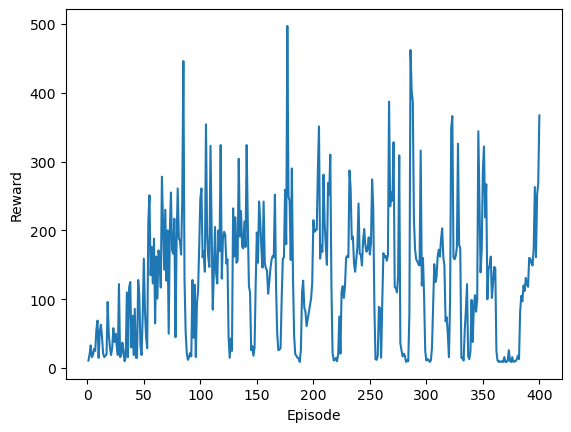

In [ ]:
epsilon = config['eps1']
episodes = config['episodes']
log = {'episodes': [], 'rewards': []}
for episode in range(1, episodes+1):
    r = run_episode(500)

    log['rewards'].append(r)
    log['episodes'].append(episode)

    epsilon *= decay
    if epsilon < config['eps2']:
        epsilon = 0.
    if episode % 100 == 0:
        clear_output(wait=True)
        print(epsilon)
        plt.plot(log['episodes'], log['rewards'])
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.show()